In [ ]:
import numpy as np
import torchvision as tvs
import torchvision.transforms as transforms 
import torch
import torch.nn as nn
import torch.nn.functional as F

# TODO get GPU compatability 

In [ ]:
num_parties = 4 # also known as k in papers... 

# TODO partition the training set (evenly) into each party 
# Lets first grab the mnist dataset 
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel grayscale to 3-channel RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
bs = 4
train = tvs.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=bs, shuffle=True, num_workers=2)
test = tvs.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=bs, shuffle=True, num_workers=2)
image, label = train[0]
input_layer_length = 1 
for x in image.shape:
    input_layer_length *= x


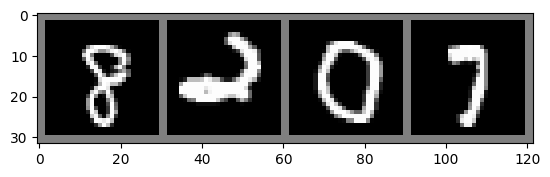

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(tvs.utils.make_grid(images))

In [67]:
# Now we define the network 

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.to_hl1 = nn.Linear(input_layer_length,250)
        self.to_hl2 = nn.Linear(250,25)
        self.to_out = nn.Linear(25,10)
        self.act = nn.Tanh()
    def forward(self, x): 
        x = self.to_hl1(x)
        x = self.act(x)
        x = self.to_hl2(x)
        x = self.act(x)
        x = self.to_out(x)
        return x

In [ ]:
import torch.optim as optim

# TODO create a set of nets (1 per party) Init with same parameters 
net = Network()

crit = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
# Note duplicate loss and optimizer too 

print(train_loader.__len__())

15000


In [ ]:
from collections import OrderedDict

def average_gradients(parties, num_parties=num_parties):
    # Initialize a dictionary to store averaged gradients
    averaged_grads = OrderedDict()
    
    # Iterate over parameters by name
    for name, param in parties[0].named_parameters():
        # Accumulate gradients across all bank models
        grads = []
        for model in parties:
            if model.state_dict()[name].grad is not None:
                grads.append(model.state_dict()[name].grad.clone())
        
        if grads:
            # Average the gradients
            total_grad = torch.stack(grads).mean(dim=0)
            averaged_grads[name] = total_grad
            
    return averaged_grads   

In [ ]:
import tqdm 

loss_ot = [] # monitors the loss over time 
granularity = 100 # a parameter that describes how many iterations we should wait till recording the loss to loss_ot 
size_D = train_loader.__len__() # the number of elements in the train data set 
epochs = 10
num_its = (size_D*epochs)/(granularity)

for epoch in range(epochs):
    print("Epoch: ", epoch)
    for i, data in tqdm.tqdm(enumerate(train_loader, 0), total=size_D):
        inputs, labels = data
        # we first zero our gradients here as we are about to do a step of gradient descent 
        opt.zero_grad()
        
        outputs = net(inputs.reshape(bs,input_layer_length))
        
        
        loss = crit(outputs,labels)
        
        loss.backward()
        # TODO Option 1: average grads here 
        averaged_gradients = average_gradients(models, num_parties)
        # Apply averaged gradients to each bank model and update with individual optimizers
        for i, bank_model in enumerate(models):
            for param_name, param in bank_model.named_parameters():
                if param_name in averaged_gradients:
                    param.grad = averaged_gradients[param_name]  # Assign averaged gradient to each model's parameter
            optimizers[i].step()  # Update each bank model using its own optimizer

        # opt.step() 
        if i % granularity == 0:
            loss_ot.append(loss.item())
            
    # TODO (LATER) for each party, (per epoch) average the model params of the parties and 
    # TODO chart test accuracy 
    # TODO also chart training loss here 
        

Epoch:  0


100%|██████████| 15000/15000 [00:53<00:00, 281.56it/s]


Epoch:  1


100%|██████████| 15000/15000 [00:52<00:00, 283.60it/s]


Epoch:  2


100%|██████████| 15000/15000 [00:54<00:00, 274.02it/s]


Epoch:  3


  0%|          | 0/15000 [00:05<?, ?it/s]


KeyboardInterrupt: 

LOSS:  0.13629364967346191


<function matplotlib.pyplot.show(close=None, block=None)>

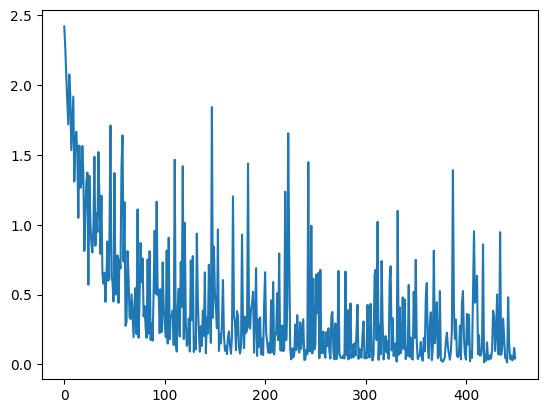

In [75]:
print("LOSS: ", loss.item())
X = np.arange(num_its)
Y = np.array(loss_ot)
plt.plot(X,Y)
plt.show